<a href="https://colab.research.google.com/github/ICBI/AIMAHEAD_GU/blob/main/main/Courses/ML_Concepts/Module_03_Model_Selection/Copy_of_Module_03_Model_and_Hyperparameter_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/AAlogo1.jpg" alt="Powered by" width="150"/>

#AI/ML for Healthcare Applications : Lab 3 Model Selection and Hyperparameter Tuning

Based on material from the Georgetown [Health Informatics and Data Science](https://healthinformatics.georgetown.edu) program and licensed under  [CC4.0](https://creativecommons.org/licenses/by/4.0/) 


The aim of this notebook is to provide an hands-on demo of selecting model and tuning hyperparameters using sklearn.

## Packages



We will start by loading some of the packages that will help us 
organize and visualize the data. Other packages will be loaded as necessary.

In [5]:
#Import packages
from collections import Counter
import pandas as pd
import numpy as np
import collections, numpy
import mlxtend
import matplotlib 
from matplotlib import pyplot 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
matplotlib.rcParams['figure.figsize'] = (10, 10)


from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.svm import SVC # "Support vector classifier"

## Dataset

We will be building and evaluating models to predict **diabetes** using using the diabetes dataset from the National Institute of Diabetes and Digestive and Kidney Diseases (**NIDDK**). 

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. 

We will be using the **NIDDK diabetes dataset**, which contains 768 female patients of at least 21 years old.  Fields in this dataset are:




* **Pregnancies:** Number of times pregnant
* **Glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* **BloodPressure:** Diastolic blood pressure (mm Hg)
* **SkinThickness:** Triceps skin fold thickness (mm)
* **Insulin:** 2-Hour serum insulin (mu U/ml)
* **BMI:** Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction:** Diabetes pedigree function
* **Age:** Age (years)
* **Outcome:** Class variable (0 or 1); class value 1 is interpreted as "tested positive for diabetes"


Let's explore the dataset. You must first obtain the data file "diabetes.csv" and upload it to a directory that is accessable by this colab notebook.

In [8]:
!wget https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/ML_Concepts/diabetes.csv
diabetes_file = "/content/diabetes.csv"

--2023-05-18 17:49:06--  https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/ML_Concepts/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24409 (24K) [text/plain]
Saving to: ‘diabetes.csv.2’

diabetes.csv.2      100%[===================>]  23.84K  --.-KB/s    in 0.001s  

2023-05-18 17:49:06 (16.2 MB/s) - ‘diabetes.csv.2’ saved [24409/24409]



In [9]:
# make a data frame
diabetes_df = pd.read_csv(diabetes_file)

Check the data frame

In [10]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [12]:
diabetes_df.shape

(768, 9)

Handle missing values

In [13]:
diabetes_df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [14]:
diabetes_df['Pregnancies'].fillna(0, inplace=True)

Replacing other missing values by median of the respective column values

In [15]:
diabetes_df['Glucose'].fillna(diabetes_df['Glucose'].median(), inplace=True)
diabetes_df['BloodPressure'].fillna(diabetes_df['BloodPressure'].median(), inplace=True)
diabetes_df['SkinThickness'].fillna(diabetes_df['SkinThickness'].median(), inplace=True)
diabetes_df['Insulin'].fillna(diabetes_df['Insulin'].median(), inplace=True)
diabetes_df['BMI'].fillna(diabetes_df['BMI'].median(), inplace=True)

In [16]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [17]:
Counter(diabetes_df['Outcome'])

Counter({1: 268, 0: 500})

Before we can train ML models, we have to seperate the features (`X`) and the outcome variable (`y`)

In [18]:
#Preparing the data for the ML models
X_df = diabetes_df.drop('Outcome',axis=1)
y_df = diabetes_df['Outcome']

In [19]:
X_df.shape, y_df.shape

((768, 8), (768,))

Split into train and test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=2)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [22]:
Counter(y_train), Counter(y_test)

(Counter({0: 391, 1: 223}), Counter({0: 109, 1: 45}))

## Cross-validation

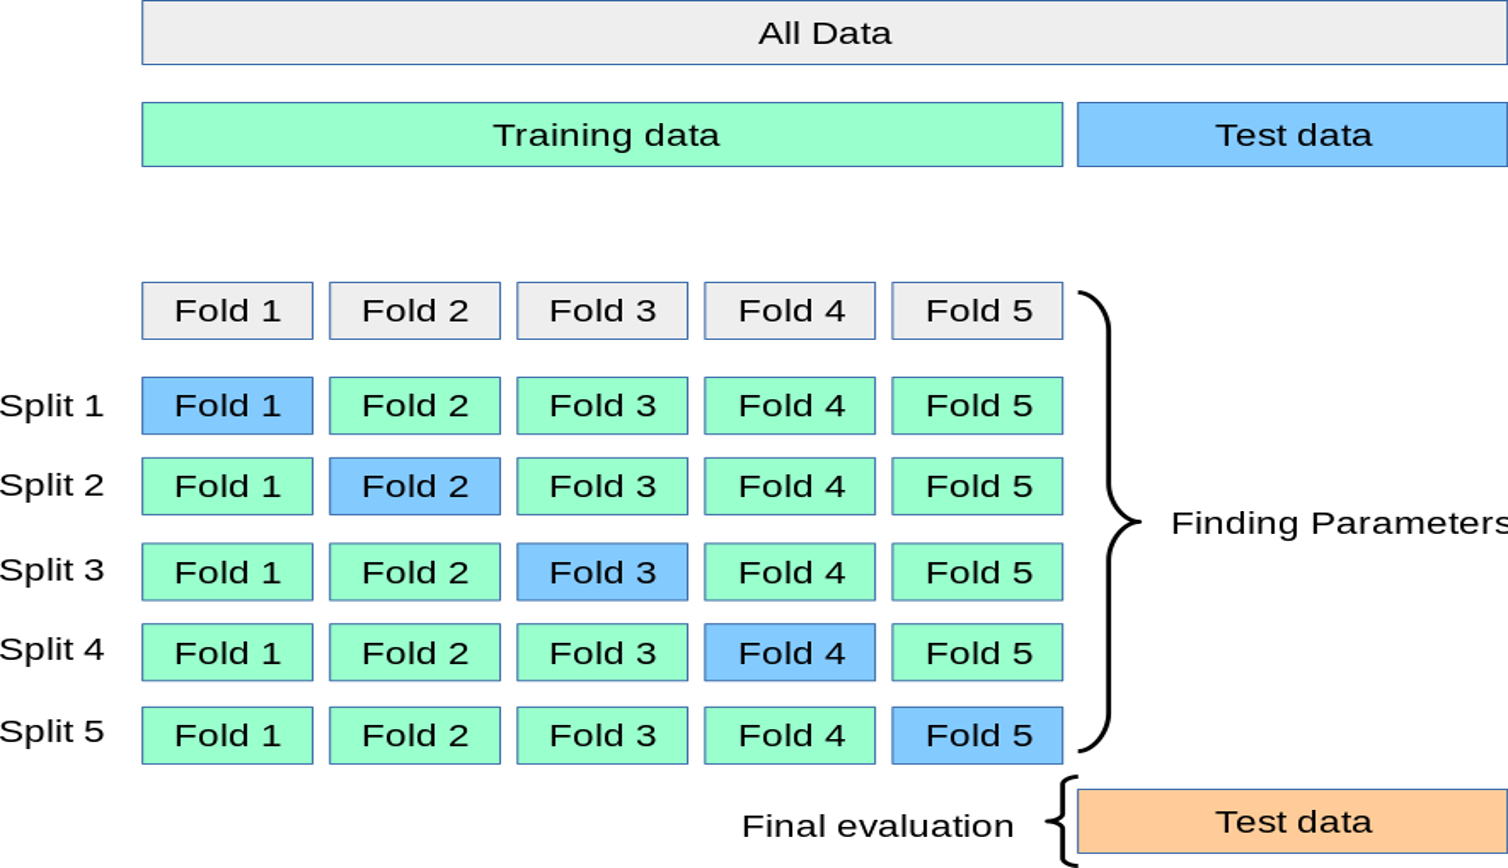

Instead of training on train set and testing on test set, we will use cross validation to evaluate a specific combination of a model and hyper parameter.
We will sklearn's `cross_validate()` function.
Details here: https://scikit-learn.org/stable/modules/cross_validation.html

In [23]:
model = LogisticRegression(max_iter= 1000,
                           penalty='l2',
                           C=0.5)

In [24]:
cross_validate(model, X_train, y_train, 
               cv=5, 
               scoring='f1')

{'fit_time': array([0.05532694, 0.02776909, 0.02508259, 0.03857803, 0.02877951]),
 'score_time': array([0.00442481, 0.00321221, 0.00330448, 0.00355721, 0.00324988]),
 'test_score': array([0.58666667, 0.62790698, 0.69230769, 0.62068966, 0.725     ])}

In [25]:
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring='f1')

In [26]:
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [27]:
cv_results['test_score'].mean()

0.6505141981781918

**Different parameter**

In [28]:
model = LogisticRegression(max_iter= 1000,
                           penalty='l2',
                           C=0.001)
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring='f1')
cv_results['test_score'].mean()

0.6408893783311589

**Different model**

In [29]:
model = SVC(kernel='linear')
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring='f1')
cv_results['test_score'].mean()

0.6338543852169197

SVM with non-linear kernel

In [30]:
model = SVC(kernel='poly')
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring='f1')
cv_results['test_score'].mean()

0.5887766396329315

Helper function to train and return results on test set

In [31]:
def train_and_test(clf, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_test_pred = clf.predict(X_test)
  print(classification_report(y_test, y_test_pred))

Fit best model and deploy

In [32]:
best_model = LogisticRegression(max_iter= 1000,
                           penalty='l2',
                           C=0.5)

In [33]:
train_and_test(best_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       109
           1       0.63      0.53      0.58        45

    accuracy                           0.77       154
   macro avg       0.73      0.70      0.71       154
weighted avg       0.76      0.77      0.77       154



## Grid Search

Using GridSearch to automatically find optimal hyperparameters using cross validation. We will use sklearn's grid search function.
Details: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [34]:
from sklearn.model_selection import GridSearchCV

Define model and a set of parameters for the model

In [35]:
model = LogisticRegression(max_iter= 1000, solver="liblinear")

In [36]:
parameters = {'penalty': ['l1', 'l2'],
              'C':[1, 10]}

Grid search returns an instance of the model with best combination parameters

In [37]:
clf = GridSearchCV(model, 
                   parameters, 
                   cv=5,
                   scoring="f1")

In [38]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [1, 10], 'penalty': ['l1', 'l2']}, scoring='f1')

In [39]:
clf.cv_results_

{'mean_fit_time': array([0.01213918, 0.00643463, 0.01137347, 0.00544357]),
 'std_fit_time': array([0.00285323, 0.00107051, 0.00073518, 0.00018306]),
 'mean_score_time': array([0.00444565, 0.00373759, 0.00381165, 0.0031086 ]),
 'std_score_time': array([1.29766637e-03, 4.97110607e-04, 1.03856231e-03, 8.15974969e-05]),
 'param_C': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'penalty': 'l1'},
  {'C': 1, 'penalty': 'l2'},
  {'C': 10, 'penalty': 'l1'},
  {'C': 10, 'penalty': 'l2'}],
 'split0_test_score': array([0.54054054, 0.56      , 0.57534247, 0.56      ]),
 'split1_test_score': array([0.61363636, 0.57831325, 0.63529412, 0.62790698]),
 'split2_test_score': array([0.6835443 , 0.63157895, 0.6835443 , 0.6835443 ]),
 'spli

In [40]:
clf.best_params_

{'C': 10, 'penalty': 'l1'}

Best parameters

In [41]:
clf.best_score_

0.6465634501668631

No need to fit the a model with best param on training set;
Grid search returns an instance of the model with best combination parameters


In [42]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       109
           1       0.62      0.51      0.56        45

    accuracy                           0.77       154
   macro avg       0.72      0.69      0.70       154
weighted avg       0.76      0.77      0.76       154



**Iterating through several models and selecting hyperparameter for each**

At the end we will output the best model

In [43]:
from sklearn.pipeline import Pipeline

In [44]:
def train_and_dump_best_model(X_train, y_train):

  X, y = X_train, y_train
  print(X.shape)
  print(y.shape)

  ###define pipelines
  # Construct some pipelines
  pipe_lr = Pipeline([('clf', LogisticRegression(random_state=42))])
  pipe_svm = Pipeline([('clf', svm.SVC(random_state=42))])
  pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

  # Set grid search params
  param_range_svm = [1, 5, 10]
  param_range_lr = [1.0, 0.5, 0.1]

  grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_lr,
		'clf__solver': ['liblinear']}] 
  
  grid_params_svm = [{'clf__kernel': ['linear'], 
		'clf__C': param_range_svm}]

  grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
    'clf__n_estimators': [10,20],
    "clf__bootstrap": [True, False],
    "clf__max_depth": [3, None],
    "clf__max_features": [1, 3, 10],
    "clf__min_samples_split": [2, 3, 10]}]

  # Construct grid searches
  jobs = -1
  folds = 5
  score = "roc_auc"
  gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring=score,
			cv=folds,
      n_jobs=jobs) 
  
  gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring=score,
			cv=folds,
			n_jobs=jobs)
  
  gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring=score,
			cv=folds, 
			n_jobs=jobs)
  
  # List of pipelines for ease of iteration
  #grids = [gs_lr, gs_svm, gs_rf]
  grids = [gs_lr, gs_svm]


  # Dictionary of pipelines and classifier types for ease of reference
  #grid_dict = {0: 'Logistic Regression', 1: 'SVM', 2: 'Random Forest'}
  grid_dict = {0: 'Logistic Regression', 1: 'SVM'}
  # Fit the grid search objects


  print('Performing model optimizations...')
  best_score = 0.0
  best_clf = 0
  best_gs = ''
  for idx, gs in enumerate(grids):
	  print('\nEstimator: %s' % grid_dict[idx])	
	  # Fit grid search	
	  gs.fit(X, y)
	  # Best params
	  print('Best params: %s' % gs.best_params_)
	  # Best training data accuracy
	  print('Best training score: %.3f' % gs.best_score_)
	  if gs.best_score_ > best_score:
		  best_score = gs.best_score_
		  best_gs = gs
		  best_clf = idx
  print('\nBest Classifier with best hyperparameters: %s' % grid_dict[best_clf])
  
  return best_gs

In [45]:
best_model_gs = train_and_dump_best_model(X_train,y_train)

(614, 8)
(614,)
Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training score: 0.840

Estimator: SVM
Best params: {'clf__C': 5, 'clf__kernel': 'linear'}
Best training score: 0.841

Best Classifier with best hyperparameters: SVM


In [46]:
y_test_pred = best_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       109
           1       0.63      0.53      0.58        45

    accuracy                           0.77       154
   macro avg       0.73      0.70      0.71       154
weighted avg       0.76      0.77      0.77       154



>>>>**I think we need some summary conclusion statement here**

**The END** <br>
**Authors: Dr. Samir Gupta, Dr. Matthew McCoy & ICBI AIM-AHEAD Team**

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/HIDSLOGO.AA1.jpg" alt="Powered by" width="500"/>
